In [1]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import sys
sys.path.append(os.path.abspath(".."))
import torch
import pandas as pd
from datasets import PressingSequenceDataset, SoccerMapInputDataset
import config as C
import features as F
from bisect import bisect_right
from collections import defaultdict


2025-06-15 10:22:39.835453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 10:22:39.835500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 10:22:39.835531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 10:22:39.843463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-15 10:22:40.756165: W tensorflow/compiler/

/home/exPress/express-v2


In [2]:
data_path = "/home/exPress/express-v2/data/bepro/pressing_intensity"

with open(f"{data_path}/train_dataset.pkl", "rb") as f:
    train_dataset = pickle.load(f)

with open(f"{data_path}/valid_dataset.pkl", "rb") as f:
    valid_dataset = pickle.load(f)

with open(f"{data_path}/test_dataset.pkl", "rb") as f:
    test_dataset = pickle.load(f)

len(train_dataset), len(valid_dataset), len(test_dataset)

(6553, 598, 637)

In [3]:
def check_game_ids(dataset):
    game_ids = set()
    for idx, sample in enumerate(dataset):
        game_id, _, _ = sample['match_info'].split('-')
        game_ids.add(game_id)
    return len(game_ids), sorted(game_ids)

print("Train Game IDs:", check_game_ids(train_dataset))
print("Valid Game IDs:", check_game_ids(valid_dataset))
print("Test Game IDs:", check_game_ids(test_dataset))


Train Game IDs: (30, ['126293', '126298', '126306', '126309', '126315', '126325', '126332', '126341', '126348', '126350', '126356', '126364', '126367', '126378', '126380', '126386', '126391', '126401', '126408', '126411', '126418', '126424', '126429', '126433', '126444', '126448', '126455', '126458', '126466', '126473'])
Valid Game IDs: (3, ['126476', '153364', '153373'])
Test Game IDs: (3, ['153379', '153385', '153387'])


In [ ]:
sample = train_dataset[0]

print(f"Features : {sample['features'].shape}")
print(f"Pressing Intensity : {sample['pressing_intensity'].shape}")
print(f"Labels : {sample['label']}")
print(f"Presser ID : {sample['presser_id']}")
print(f"Players Order : {sample['agent_order']}")
print(f"match info : {sample['match_info']}")

In [3]:
from collections import defaultdict
import torch
import pandas as pd
import os

def transform_feature_dict(feature_dict):
    """
    주어진 feature_dict의 값을 [0, 1] 범위로 Min-Max 스케일링합니다.
    결측치(NaN)는 변환 과정에서 제외되며, 최종적으로는 0.0으로 처리됩니다.
    """
    vals = [v for v in feature_dict.values() if pd.notna(v)]
    
    if not vals: # 값이 없거나 모두 NaN인 경우
        return {k: 0.0 if pd.isna(v) else v for k, v in feature_dict.items()} # 모든 NaN을 0.0으로, 그 외는 그대로 둠

    min_val = min(vals)
    max_val = max(vals)
    
    # 0으로 나누는 오류 방지: max_val과 min_val이 같으면 (모든 유효한 값이 동일하면) 1.0으로 나눔
    range_val = max_val - min_val if max_val != min_val else 1.0 
    
    transformed_dict = {}
    for k, v in feature_dict.items():
        if pd.notna(v):
            transformed_dict[k] = (v - min_val) / range_val
        else:
            transformed_dict[k] = 0.0 # NaN 값은 0.0으로 처리
    return transformed_dict

def update_features(dataset, feature_list, processed_data_path, transform = True, cache_dir="feature_cache"):
    os.makedirs(cache_dir, exist_ok=True)
    game_sample_map = defaultdict(list)

    # 1. game_id 기준으로 샘플 인덱스와 frame_id를 모음
    for idx, sample in enumerate(dataset): # dataset.__len__에 의해 결정되는 길이만큼 루프
        game_id, period_id_str, frame_id_str = sample['match_info'].split('-')
        frame_id = int(frame_id_str)
        period_id = int(float(period_id_str))
        game_sample_map[game_id].append((idx, period_id, frame_id))


    # 2. game_id 단위로 모든 처리 (데이터 로드, timestamp 매핑, 피처 계산, 데이터셋 업데이트)
    for game_id, frame_infos_for_game in game_sample_map.items():
        game_feature_dir = os.path.join(cache_dir, game_id)
        os.makedirs(game_feature_dir, exist_ok=True)
        print(f"\n--- Processing Game ID: {game_id} ---")

        tracking_df = pd.read_csv(os.path.join(processed_data_path, game_id, f"{game_id}_traces.csv"))
        events_df = pd.read_csv(os.path.join(processed_data_path, game_id, f"{game_id}_merged.csv"))
        teams_df = pd.read_csv(os.path.join(processed_data_path, game_id, f"{game_id}_teams.csv"))
        events_df["time_seconds"] = pd.to_numeric(events_df["time_seconds"], errors="coerce")

        # 2-1. frame_id -> timestamp 매핑 (스코프가 이 루프 내부로 제한됨)
        frame_id_to_ts = tracking_df.set_index(['period_id', 'frame_id'])['time_seconds'].to_dict() 

        precomputed_game_features = {} 
        # 2-2. 일단 전체에 대해 계산 진행
        for feature_name in feature_list: # 각 피처 이름에 대해
            feature_cache_path = os.path.join(game_feature_dir, f"{feature_name}.pkl")
            if os.path.exists(feature_cache_path):
                with open(feature_cache_path, 'rb') as f:
                    feat_result_df = pickle.load(f)
            else:
                func = getattr(F, feature_name)
                game_feature_dir = os.path.join(cache_dir, game_id)
                os.makedirs(game_feature_dir, exist_ok=True)
                if feature_name == "sum_pitch_control":
                    feat_result_df  = func(events_df, teams_df)                              
                else:
                    feat_result_df = func(events_df)  # Series with index=action_id
                with open(feature_cache_path, 'wb') as f:
                    pickle.dump(feat_result_df, f)
            raw_dict = feat_result_df.set_index('action_id')[feature_name].to_dict() 
            
            if transform:
                precomputed_game_features[feature_name] = transform_feature_dict(raw_dict)
            else:
                precomputed_game_features[feature_name] = raw_dict
                
        # 2-3. 샘플별 과거 이벤트 B개에 대해 feature 추출
        for sample_idx, period_id, fid in frame_infos_for_game: 
            ts = frame_id_to_ts.get((period_id, fid)) 
            current_sample_data_dict = dataset[sample_idx] 
            original_feature_tensor = current_sample_data_dict['features'] 
            B, N, D = original_feature_tensor.shape # B는 이 샘플의 과거 이벤트 수 (context_length)
            past_events = events_df[events_df["time_seconds"] < ts].head(B)
            event_ids = past_events["action_id"].tolist()

            # 각 feature별로 (B, 1) 텐서를 생성하고 합치기
            new_feature_list = []
            for feature_name in feature_list:
                feat_dict = precomputed_game_features[feature_name]
                feat_vals = [feat_dict.get(eid, np.nan) for eid in event_ids]  # (B,)
                feat_tensor = torch.tensor(feat_vals, dtype=torch.float32).view(B, 1)  # (B, 1)
                expanded = feat_tensor.unsqueeze(1).expand(-1, N, -1)  # (B, N, 1)
                new_feature_list.append(expanded)

            # 모든 feature 통합
            new_concat = torch.cat(new_feature_list, dim=-1)  # (B, N, F')
            final_feature_tensor = torch.cat([original_feature_tensor, new_concat], dim=-1)
            current_sample_data_dict['features'] = final_feature_tensor
            dataset[sample_idx] = current_sample_data_dict  # 최종 저장
            



In [5]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.backends
def visualize(df, index):
    row = df.iloc[index]

    # 피치 좌표계: 왼쪽 아래가 (0,0)
    pitch = Pitch(pitch_type='custom',
                  pitch_length=105, pitch_width=68,
                  line_color='white',
                  axis=True,  # ✅ 축 표시
                  label=True,  # ✅ 축 눈금값 라벨 표시
                  pitch_color='grass',
                  stripe=True)
    fig, ax = pitch.draw()

    # 홈팀
    home_x, home_y = [], []
    for i in range(20):
        x, y = row.get(f'H{i:02}_x'), row.get(f'H{i:02}_y')
        if pd.notna(x) and pd.notna(y):
            x += 52.5
            y += 34
            home_x.append(x); home_y.append(y)
            pitch.annotate(str(i), (x, y), ax=ax,
                           va='center', ha='center', color='white', fontsize=10)
    pitch.scatter(home_x, home_y, ax=ax, color='blue', s=200, label='Home')

    # 어웨이팀
    away_x, away_y = [], []
    for i in range(20):
        x, y = row.get(f'A{i:02}_x'), row.get(f'A{i:02}_y')
        if pd.notna(x) and pd.notna(y):
            x += 52.5
            y += 34
            away_x.append(x); away_y.append(y)
            pitch.annotate(str(i), (x, y), ax=ax,
                           va='center', ha='center', color='white', fontsize=10)
    pitch.scatter(away_x, away_y, ax=ax, color='red', s=200, label='Away')

    # 공
    ball_x, ball_y = row['ball_x'] + 52.5, row['ball_y'] + 34
    pitch.scatter(ball_x, ball_y, ax=ax, color='yellow', s=100,
                  edgecolors='black', linewidth=1.0, label='Ball')

    # 시간 표시
    time_str = str(row['timestamp']).split(' ')[-1].split('.')[0]
    plt.title(f"Player Positions at {time_str}")
    plt.legend(loc='upper right')
    plt.show()


In [49]:
game_id = "126285"
tracking = pd.read_csv(os.path.join(processed_data_path, game_id, f"{game_id}_traces.csv"))
merged = pd.read_csv(os.path.join(processed_data_path, game_id, f"{game_id}_merged.csv"))


In [50]:
merged

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,relative_player_id,reactor_team_id,reactor_player_id,type_name,...,H07_y,H08_y,H09_y,H10_y,H13_y,H14_y,H17_y,H18_y,H19_y,ball_y
0,126285,0.0,0,1,1.501,2.334,77414.0,-1,-1.0,Pass,...,20.775700,-9.819000,8.185700,0.460700,NaN,NaN,NaN,NaN,NaN,1.287600
1,126285,1.0,1,1,2.334,NaN,-1.0,-1,-1.0,Pass Received,...,21.396381,-9.720638,8.150633,0.434467,NaN,NaN,NaN,NaN,NaN,7.666288
2,126285,2.0,2,1,3.101,4.134,250101.0,-1,-1.0,Pass,...,22.872612,-9.770800,7.670211,0.224064,NaN,NaN,NaN,NaN,NaN,6.976466
3,126285,3.0,3,1,4.134,NaN,-1.0,-1,-1.0,Pass Received,...,25.129511,-9.909202,7.149500,0.153235,NaN,NaN,NaN,NaN,NaN,0.855635
4,126285,4.0,4,1,5.334,6.567,62365.0,-1,-1.0,Pass,...,27.855749,-10.644210,7.271486,0.042221,NaN,NaN,NaN,NaN,NaN,-1.271192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,126285,3907.0,2882,2,6077.700,3169.700,500135.0,-1,-1.0,Pass,...,NaN,NaN,NaN,NaN,-10.061876,10.429031,-3.469172,-7.134088,0.830803,-13.952637
2883,126285,3914.0,2883,2,6080.367,NaN,-1.0,-1,-1.0,Pass Received,...,NaN,NaN,NaN,NaN,-12.943486,9.728600,-2.573310,-9.414626,2.252752,-29.170548
2884,126285,NaN,2884,2,6080.368,NaN,NaN,-1,-1.0,Carry,...,NaN,NaN,NaN,NaN,-12.943486,9.728600,-2.573310,-9.414626,2.252752,-29.170548
2885,126285,3916.0,2885,2,6084.100,NaN,-1.0,-1,-1.0,Take-On,...,NaN,NaN,NaN,NaN,-16.957700,9.917300,-8.309600,-11.513700,9.875700,-34.000000


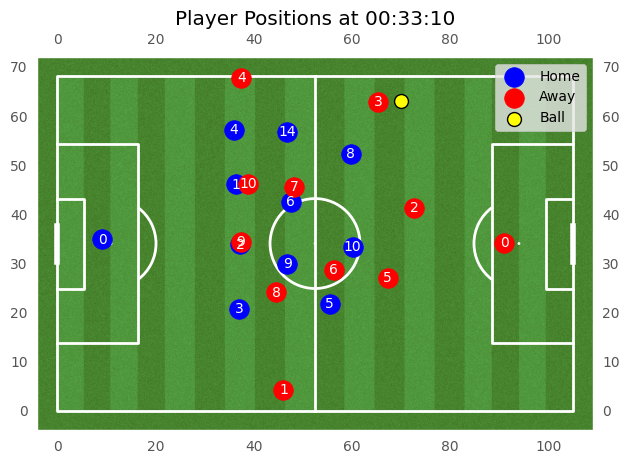

In [136]:
visualize(merged, 900)

In [98]:
tracking_df[tracking_df['period_id']==2].head()

,period_id,timestamp,frame_id,A00_a,A01_a,A02_a,A03_a,A04_a,A05_a,A06_a,...,H08_y,H09_y,H10_y,H13_y,H14_y,H17_y,H18_y,H19_y,ball_y,time_seconds
72727,2,0 days 00:45:01,67525,0.662648,1.050887,0.240793,0.058833,1.752869,0.765920,0.538768,...,7.710100,-9.258400,10.506300,NaN,-20.377400,NaN,NaN,NaN,1.187400,2910.64
72728,2,0 days 00:45:01.040000,67526,0.487203,0.917352,0.245655,0.100806,1.681606,0.772976,0.612659,...,7.713697,-9.253256,10.489372,NaN,-20.355689,NaN,NaN,NaN,1.152856,2910.68
72729,2,0 days 00:45:01.080000,67527,0.380401,0.773825,0.103495,0.220340,1.354960,0.832303,0.658633,...,7.716855,-9.247601,10.470518,NaN,-20.332732,NaN,NaN,NaN,1.118749,2910.72
72730,2,0 days 00:45:01.120000,67528,0.374617,0.637176,0.136450,0.243057,1.301295,1.092554,0.607243,...,7.719700,-9.241223,10.449868,NaN,-20.308291,NaN,NaN,NaN,1.084830,2910.76
72731,2,0 days 00:45:01.160000,67529,0.523184,0.464094,0.237912,0.246020,1.286113,1.356220,0.561565,...,7.722474,-9.233869,10.426943,NaN,-20.281515,NaN,NaN,NaN,1.050226,2910.80


In [40]:
def print_feature_shape_diff(dataset, dataset_name="dataset"):
    print(f"[{dataset_name}] Feature shape before update:")
    for i in range(3):  # 앞의 3개 샘플만 예시로 확인
        print(f"  Sample {i}: {dataset[i]['features'].shape}")

# 1. 업데이트 전
print_feature_shape_diff(train_dataset, "train_dataset (before)")
print_feature_shape_diff(test_dataset, "test_dataset (before)")

[train_dataset (before)] Feature shape before update:
  Sample 0: torch.Size([2, 23, 38])
  Sample 1: torch.Size([1, 23, 38])
  Sample 2: torch.Size([1, 23, 38])
[test_dataset (before)] Feature shape before update:
  Sample 0: torch.Size([4, 23, 38])
  Sample 1: torch.Size([4, 23, 38])
  Sample 2: torch.Size([2, 23, 38])


In [4]:
processed_data_path = "/home/exPress/express-v2/data/bepro/processed"
feature_list = [
                'distance_ball_goal', 'distance_ball_sideline', 'action_type',
                'distance_ball_goalline', 'actor_speed', 'angle_to_goal', 
                'elapsed_time', 'time_since_last_opponent_action', 'def_goal', 'att_goal', 'goal_diff', 'closest_defender_dist', 
                'closest_defender_speed', 'speed_diff_actor_defender', 'nb_of_3m_radius', 'nb_of_5m_radius','nb_of_10m_radius', 
                'dist_defender_to_sideline','dist_defender_to_goaline', 'diff_ball_defender_goalline', 'diff_ball_defender_sideline',
                # 'sum_pitch_control'
                ]

update_features(train_dataset, feature_list, processed_data_path, transform=False, cache_dir="/home/exPress/express-v2/data/bepro/feature")
update_features(valid_dataset, feature_list, processed_data_path, transform=False, cache_dir="/home/exPress/express-v2/data/bepro/feature")
update_features(test_dataset, feature_list, processed_data_path, transform=False, cache_dir="/home/exPress/express-v2/data/bepro/feature")


--- Processing Game ID: 126293 ---

--- Processing Game ID: 126298 ---

--- Processing Game ID: 126306 ---

--- Processing Game ID: 126309 ---

--- Processing Game ID: 126315 ---

--- Processing Game ID: 126325 ---

--- Processing Game ID: 126332 ---

--- Processing Game ID: 126341 ---

--- Processing Game ID: 126348 ---

--- Processing Game ID: 126350 ---

--- Processing Game ID: 126356 ---

--- Processing Game ID: 126364 ---

--- Processing Game ID: 126367 ---

--- Processing Game ID: 126378 ---

--- Processing Game ID: 126380 ---

--- Processing Game ID: 126386 ---

--- Processing Game ID: 126391 ---

--- Processing Game ID: 126401 ---

--- Processing Game ID: 126408 ---

--- Processing Game ID: 126411 ---

--- Processing Game ID: 126418 ---

--- Processing Game ID: 126424 ---

--- Processing Game ID: 126429 ---

--- Processing Game ID: 126433 ---

--- Processing Game ID: 126444 ---

--- Processing Game ID: 126448 ---

--- Processing Game ID: 126455 ---

--- Processing Game ID: 126

In [5]:
def print_feature_shape_diff(dataset, dataset_name="dataset"):
    print(f"[{dataset_name}] Feature shape before update:")
    for i in range(3):  # 앞의 3개 샘플만 예시로 확인
        print(f"  Sample {i}: {dataset[i]['features'].shape}")

# 1. 업데이트 전
print_feature_shape_diff(train_dataset, "train_dataset (after)")
print_feature_shape_diff(valid_dataset, "valid dataset (after)")
print_feature_shape_diff(test_dataset, "test_dataset (after)")

[train_dataset (after)] Feature shape before update:
  Sample 0: torch.Size([2, 23, 39])
  Sample 1: torch.Size([1, 23, 39])
  Sample 2: torch.Size([1, 23, 39])
[valid dataset (after)] Feature shape before update:
  Sample 0: torch.Size([2, 23, 39])
  Sample 1: torch.Size([4, 23, 39])
  Sample 2: torch.Size([2, 23, 39])
[test_dataset (after)] Feature shape before update:
  Sample 0: torch.Size([4, 23, 39])
  Sample 1: torch.Size([4, 23, 39])
  Sample 2: torch.Size([2, 23, 39])


In [29]:
def reorder_features_by_distance_to_ball(dataset, distance_feature_idx=14):
    """
    dataset의 각 샘플에 대해 'features' 텐서를 공과의 거리에 따라 재정렬합니다.

    Args:
        dataset (list or Dataset object): 각 샘플이 'features' 키를 가진 딕셔너리인 데이터셋.
                                        features 텐서는 (B, N, D) 형태를 가정합니다.
        distance_feature_idx (int): 공과의 거리를 나타내는 feature의 인덱스 (0-based).
                                    (여기서는 14)

    Returns:
        None: dataset을 직접 수정합니다.
    """
    print(f"Applying feature reordering based on feature at index {distance_feature_idx}...")
    
    for sample_idx in range(len(dataset)):
        sample = dataset[sample_idx]
        features_tensor = sample['features'] # (B, N, D)

        B, N, D = features_tensor.shape

        # 각 시점 (B) 에 대해 독립적으로 정렬을 수행합니다.
        reordered_features = []
        for t in range(B): # t는 시퀀스의 각 타임스텝
            current_time_step_features = features_tensor[t] # (N, D)

            # 14번째 인덱스 (공과의 거리) 피처 값들을 추출
            distances = current_time_step_features[:, distance_feature_idx] # (N,)

            # 거리를 기준으로 오름차순 정렬할 인덱스를 얻음 (가장 가까운 선수부터)
            # torch.argsort는 기본적으로 오름차순 정렬
            sorted_indices = torch.argsort(distances, dim=0) # (N,)

            # 정렬된 인덱스에 따라 현재 시점의 모든 피처를 재정렬
            reordered_time_step_features = current_time_step_features[sorted_indices] # (N, D)
            reordered_features.append(reordered_time_step_features)
        
        # 재정렬된 시점별 특징들을 다시 (B, N, D) 텐서로 합침
        sample['features'] = torch.stack(reordered_features, dim=0) # (B, N, D)
        dataset[sample_idx] = sample # 데이터셋에 업데이트 (파이썬 리스트라면 필수)
    
    print("Feature reordering complete.")

reorder_features_by_distance_to_ball(train_dataset, distance_feature_idx=13)
reorder_features_by_distance_to_ball(valid_dataset, distance_feature_idx=13)
reorder_features_by_distance_to_ball(test_dataset, distance_feature_idx=13)


Applying feature reordering based on feature at index 13...
Feature reordering complete.
Applying feature reordering based on feature at index 13...
Feature reordering complete.
Applying feature reordering based on feature at index 13...
Feature reordering complete.


In [41]:
''
'distance_ball_goal', 'distance_ball_sideline',
'distance_ball_goalline', 'actor_speed', 'angle_to_goal', 
'elapsed_time', 'time_since_last_opponent_action', 'def_goal', 'att_goal', 'goal_diff', 'closest_defender_dist', 
'closest_defender_speed', 'speed_diff_actor_defender', 'nb_of_3m_radius', 'nb_of_5m_radius','nb_of_10m_radius', 
'dist_defender_to_sideline','dist_defender_to_goaline', 'diff_ball_defender_goalline', 'diff_ball_defender_sideline',
'sum_pitch_control'

''
array([ 63.34536  ,  28.980858 ,  41.853798 ,   0.564949 , 175.45543  ,
         2.533    ,   3.533    ,   9.720406 ,   2.4472604,  -1.8823115,
         0.       ,   0.       ,   1.       ,  25.220808 ,  54.18248  ,
         8.963721 ,   3.76005  ], dtype=float32)
sample = train_dataset[0]
sample['features'][0,:,13]

tensor([ 0.0000,  0.9274,  7.5746,  9.0970, 14.1093, 14.7879, 15.4391, 16.4516,
        16.9526, 18.5054, 18.5584, 20.9134, 21.5560, 22.2206, 26.8689, 27.2618,
        28.7189, 28.9554, 29.1949, 30.7041, 33.3147, 37.5731, 59.1703])

In [8]:
sample['features'].shape

torch.Size([3, 23, 39])

In [80]:
agent_feat = sample['features'][-1:, :, selected_player_features_idx]  # shape: (1, 23, 18)
agent_flat = agent_feat.flatten().numpy()  # shape: (1 × 23 × 18,) → (414,)
agent_flat

array([ 15.709209, -27.994703,  15.564624, -27.136995,  19.369726,
       -28.058235,   9.138628, -22.104376,   9.726152, -17.16991 ,
        14.993437, -12.700926,  31.91608 , -21.430986,  22.186754,
        -5.55007 ,  40.423946, -27.787971,  21.021467,  -2.209681,
        -1.04498 ,  -7.318297,  35.31857 ,  -6.895184,  40.350407,
        -8.13664 ,  38.445786,  -4.816209,  48.01925 , -33.548664,
        15.533942,   5.317207,  38.95361 ,  -2.231477,  23.875313,
         6.437243,  31.949451,   7.77845 ,  50.215534,  -3.194188,
        38.618828,   8.683191,  19.966995,  15.23853 , -22.463476,
        -1.025361], dtype=float32)

In [78]:
global_feat = sample['features'][-1, 0, selected_global_features_idx].numpy()  # shape: (20,)
global_feat

array([6.67400599e-01, 8.16319644e-01, 2.87616521e-01, 1.02847636e-01,
       5.13533950e-01, 3.37816484e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.00000000e-01, 4.72791433e-01, 3.41001779e-01,
       3.55325788e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.06617415e-01, 5.12490869e-01, 4.66395795e-01, 1.92525223e-01],
      dtype=float32)

In [81]:
feature_vector = np.concatenate([agent_flat, global_feat])
feature_vector

array([ 1.57092094e+01, -2.79947033e+01,  1.55646238e+01, -2.71369953e+01,
        1.93697262e+01, -2.80582352e+01,  9.13862801e+00, -2.21043758e+01,
        9.72615242e+00, -1.71699104e+01,  1.49934368e+01, -1.27009258e+01,
        3.19160805e+01, -2.14309864e+01,  2.21867542e+01, -5.55006981e+00,
        4.04239464e+01, -2.77879715e+01,  2.10214672e+01, -2.20968103e+00,
       -1.04498005e+00, -7.31829691e+00,  3.53185692e+01, -6.89518404e+00,
        4.03504066e+01, -8.13663960e+00,  3.84457855e+01, -4.81620884e+00,
        4.80192490e+01, -3.35486641e+01,  1.55339422e+01,  5.31720686e+00,
        3.89536095e+01, -2.23147702e+00,  2.38753128e+01,  6.43724298e+00,
        3.19494514e+01,  7.77845001e+00,  5.02155342e+01, -3.19418812e+00,
        3.86188278e+01,  8.68319130e+00,  1.99669952e+01,  1.52385302e+01,
       -2.24634762e+01, -1.02536094e+00,  6.67400599e-01,  8.16319644e-01,
        2.87616521e-01,  1.02847636e-01,  5.13533950e-01,  3.37816484e-04,
        0.00000000e+00,  

In [35]:
num_seq = 150
num_agents = 11
use_pressing_intensity = False

selected_player_features_idx = [i for i in range(2)] # 0부터 17까지 18개

# 글로벌 피처 (예: 경기 전체의 통계, 특정 이벤트의 총합 등) - 샘플당 단일 값
selected_global_features_idx = [i for i in range(18, 39)]

train_features = []
train_labels = []
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    features = sample['features'] 
    seq_len = features.shape[0]

    # [-2] 시점이 없으면 해당 sample은 스킵
    if seq_len < 1:
        continue

    agent_feat = sample['features'][-1:, :, selected_player_features_idx]  # shape: (1, 23, 18)
    agent_flat = agent_feat.flatten().numpy()  # shape: (1 × 23 × 18,) → (414,)

    global_feats = []
    for t in [-1]:
        global_feats.append(features[t, 0, selected_global_features_idx].numpy())
    global_feat_concat = np.concatenate(global_feats)  # shape: (2 × 20,)

    # # # 2. global features: 한 agent (예: 첫 번째 agent) 기준으로만 가져오기
    # global_feat = sample['features'][-1, 0, selected_global_features_idx].numpy()  # shape: (20,)
    # # global_flat = sample['features'][-1:, :, selected_global_features_idx].flatten().numpy()  # shape: (20,)

    y_tensor = sample['label']
    feature_vector = np.concatenate([agent_flat, global_feat_concat])
    # feature_vector = global_flat
    # feature_vector = global_feat_concat
    
    if use_pressing_intensity:
        press_intensity = sample['pressing_intensity'][-1:]
        if press_intensity.shape[1] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], num_agents-press_intensity.shape[1], press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=1)
            
        if press_intensity.shape[2] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], press_intensity.shape[1], num_agents-press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=2)
        
        press_vector = press_intensity.flatten().numpy()
        # Concatenate the flattened sequence data with the pressing intensity
        feature_vector = np.concatenate((feature_vector, press_vector))
    train_features.append(feature_vector)
    train_labels.append(y_tensor.item())
    
valid_features = []
valid_labels = []
for i in range(len(valid_dataset)):
    sample = valid_dataset[i]
    features = sample['features']  # shape: (T, N, F)
    seq_len = features.shape[0]
    if seq_len < 1:
        continue

    agent_feat = sample['features'][-1:, :, selected_player_features_idx]  # shape: (1, 23, 18)
    agent_flat = agent_feat.flatten().numpy()  # shape: (1 × 23 × 18,) → (414,)
    
    global_feats = []
    for t in [-1]:
        global_feats.append(features[t, 0, selected_global_features_idx].numpy())
    global_feat_concat = np.concatenate(global_feats)  # shape: (2 × 20,)

    # # # 2. global features: 한 agent (예: 첫 번째 agent) 기준으로만 가져오기
    # global_feat = sample['features'][-1, 0, selected_global_features_idx].numpy()  # shape: (20,)
    # # global_flat = sample['features'][-1:, :, selected_global_features_idx].flatten().numpy()  # shape: (20,)

    y_tensor = sample['label']    
    feature_vector = np.concatenate([agent_flat, global_feat_concat])
    # feature_vector = global_flat
    # feature_vector = global_feat_concat
    

    if use_pressing_intensity:
        press_intensity = sample['pressing_intensity'][-1:]
        if press_intensity.shape[1] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], num_agents-press_intensity.shape[1], press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=1)
            
        if press_intensity.shape[2] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], press_intensity.shape[1], num_agents-press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=2)
        
        press_vector = press_intensity.flatten().numpy()
        # Concatenate the flattened sequence data with the pressing intensity
        feature_vector = np.concatenate((feature_vector, press_vector))
    valid_features.append(feature_vector)
    valid_labels.append(y_tensor.item())


test_features = []
test_labels = []
for i in range(len(test_dataset)):
    sample = test_dataset[i]
    features = sample['features']  # shape: (T, N, F)
    seq_len = features.shape[0]

    if seq_len < 1:
        continue

    agent_feat = sample['features'][-1:, :, selected_player_features_idx]  # shape: (1, 23, 18)
    agent_flat = agent_feat.flatten().numpy()  # shape: (1 × 23 × 18,) → (414,)

    # global_feat = sample['features'][-1, 0, selected_global_features_idx].numpy()  # shape: (20,)
    # # global_flat = sample['features'][-1:, :, selected_global_features_idx].flatten().numpy()  # shape: (20,)
    global_feats = []
    for t in [-1]:
        global_feats.append(features[t, 0, selected_global_features_idx].numpy())
    global_feat_concat = np.concatenate(global_feats)  # shape: (2 × 20,)


    y_tensor = sample['label']
    feature_vector = np.concatenate([agent_flat, global_feat_concat])
    # feature_vector = global_flat
    # feature_vector = global_feat_concat
    
    if use_pressing_intensity:
        press_intensity = sample['pressing_intensity'][-1:]
        if press_intensity.shape[1] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], num_agents-press_intensity.shape[1], press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=1)
        if press_intensity.shape[2] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], press_intensity.shape[1], num_agents-press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=2)
        
        press_vector = press_intensity.flatten().numpy()
        # Concatenate the flattened sequence data with the pressing intensity
        feature_vector = np.concatenate((feature_vector, press_vector))
    test_features.append(feature_vector)
    test_labels.append(y_tensor.item())

X_train = np.array(train_features)
y_train = np.array(train_labels)

X_valid = np.array(valid_features)
y_valid = np.array(valid_labels)

X_test = np.array(test_features)
y_test = np.array(test_labels)

# Split the data into training and testing sets (80% training, 20% testing)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [36]:
X_train.shape, X_valid.shape, X_test.shape

((6553, 67), (598, 67), (637, 67))

In [24]:
X_train[0]

array([6.3345360e+01, 2.8980858e+01, 1.3000000e+01, 4.1853798e+01,
       5.6494898e-01, 1.7545543e+02, 2.5330000e+00, 3.5330000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.7204056e+00,
       2.4472604e+00, 1.8823115e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 2.5220808e+01, 5.4182480e+01, 8.9637213e+00,
       3.7600501e+00, 5.3380852e+01, 3.3941898e+01, 1.5000000e+01,
       5.1619179e+01, 3.7456214e-01, 1.7993764e+02, 1.3000000e+00,
       3.5330000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       9.0432444e+00, 3.5009497e-01, 2.4467180e-02, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 2.4934401e+01, 5.2577572e+01,
       8.0325001e-01, 9.0074997e+00], dtype=float32)

In [12]:
def print_dataset_distribution(y_train, y_val, y_test):
    def _print_split(name, labels):
        total = len(labels)
        unique, counts = np.unique(labels, return_counts=True)
        print(f"{name} Set:")
        print(f"  Total samples: {total}")
        for label, count in zip(unique, counts):
            percent = (count / total) * 100
            print(f"    Label {label}: {count:>5} samples ({percent:5.2f}%)")
        print("-" * 40)

    print("\n📊 Dataset Distribution Summary")
    print("=" * 40)
    _print_split("Train", y_train)
    _print_split("Validation", y_val)
    _print_split("Test", y_test)

print_dataset_distribution(y_train, y_valid, y_test)


📊 Dataset Distribution Summary
Train Set:
  Total samples: 6553
    Label 0:  4727 samples (72.13%)
    Label 1:  1826 samples (27.87%)
----------------------------------------
Validation Set:
  Total samples: 598
    Label 0:   433 samples (72.41%)
    Label 1:   165 samples (27.59%)
----------------------------------------
Test Set:
  Total samples: 637
    Label 0:   468 samples (73.47%)
    Label 1:   169 samples (26.53%)
----------------------------------------


In [41]:
# Create XGBoost DMatrix objects for train and test sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# # Set XGBoost training parameters
# params = {
#     'objective': 'binary:logistic',  # binary classification
#     'eval_metric': 'auc',            # evaluation metric: AUC
#     'max_depth': 6,                  # maximum depth of trees
#     'eta': 0.1,                      # learning rate
#     'seed': 42
# }
# # Specify the watchlist to evaluate performance on training and test sets during training
# num_rounds = 100

scale_pos_weight_val = 4736 / 1833 
{'colsample_bytree': 0.9, 'eta': 0.03, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.6}
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 7,                # 약간 줄여서 시작
    'eta': 0.05,                   # 학습률을 줄여서 더 많은 라운드를 학습하도록 유도
    'subsample': 0.6,              # 샘플링
    'colsample_bytree': 0.8,       # 피처 샘플링
    'min_child_weight': 3,         # 기본값 유지 또는 2~3 시도
    'gamma': 0,                  # 감마 설정
    'scale_pos_weight': scale_pos_weight_val, # 불균형 처리 (가장 중요)
    'n_estimators': 200,
    'seed': 42,
    # 'tree_method': 'hist',       # 데이터가 크면 속도 향상을 위해 사용 고려 (CPU)
    # 'grow_policy': 'lossguide'   # tree_method='hist'와 함께 사용 (불균형 데이터셋에 유리할 수 있음)
}

num_rounds = 500 # eta를 줄였으므로 라운드 수를 늘립니다.
early_stopping_rounds = 30 # 더 길게 봐서 최적의 라운드 찾도록 설정

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [42]:
bst = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=20)

/opt/conda/envs/expressv2/lib/python3.11/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.70874	eval-auc:0.58513
[1]	train-auc:0.75740	eval-auc:0.58207
[2]	train-auc:0.78427	eval-auc:0.60566
[3]	train-auc:0.80772	eval-auc:0.63138
[4]	train-auc:0.82888	eval-auc:0.64391
[5]	train-auc:0.83884	eval-auc:0.63850
[6]	train-auc:0.84482	eval-auc:0.64739
[7]	train-auc:0.84856	eval-auc:0.65992
[8]	train-auc:0.85277	eval-auc:0.65688
[9]	train-auc:0.85888	eval-auc:0.65814
[10]	train-auc:0.86621	eval-auc:0.65980
[11]	train-auc:0.86824	eval-auc:0.66189
[12]	train-auc:0.87149	eval-auc:0.66177
[13]	train-auc:0.87537	eval-auc:0.66322
[14]	train-auc:0.87690	eval-auc:0.66413
[15]	train-auc:0.88139	eval-auc:0.66566
[16]	train-auc:0.88288	eval-auc:0.66650
[17]	train-auc:0.88538	eval-auc:0.66557
[18]	train-auc:0.88965	eval-auc:0.66718
[19]	train-auc:0.89155	eval-auc:0.66990
[20]	train-auc:0.89412	eval-auc:0.67382
[21]	train-auc:0.89667	eval-auc:0.67063
[22]	train-auc:0.89958	eval-auc:0.67438
[23]	train-auc:0.90292	eval-auc:0.67838
[24]	train-auc:0.90526	eval-auc:0.68107
[25]	train

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

scale_pos_weight_val = 4736 / 1833

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    seed=42,
    scale_pos_weight=scale_pos_weight_val,
)

# parameter grid 설정
param_grid = {
    'max_depth': [8, 10, 12],
    'eta': [0.05, 0.03],
    'min_child_weight': [3, 4, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 0.9],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8, ...], 'eta': [0.05, 0.03], 'max_depth': [8, 10, ...], 'min_child_weight': [3, 4, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [43]:
print("Best parameters:", grid_search.best_params_)
print("Best AUC score :", grid_search.best_score_)

Best parameters: {'colsample_bytree': 0.9, 'eta': 0.03, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.6}
Best AUC score : 0.6510439159558835


In [39]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    brier_score_loss, log_loss
)
# W/O Pressing Intensity
# Get predictions on the test set
y_pred = bst.predict(dvalid)
y_pred_label = (y_pred > 0.5).astype(int)

# Metric 계산
accuracy = accuracy_score(y_valid, y_pred_label)
auc = roc_auc_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred_label)
brier = brier_score_loss(y_valid, y_pred)
logloss = log_loss(y_valid, y_pred)

# 출력
print(f"Accuracy     : {accuracy:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"F1-score     : {f1:.4f} ↑")            # ↑ 좋을수록 좋음
print(f"Brier Score  : {brier:.4f} ↓")         # ↓ 낮을수록 좋음
print(f"Log Loss     : {logloss:.4f} ↓")       # ↓ 낮을수록 좋음

Accuracy     : 0.7191
AUC          : 0.6734
F1-score     : 0.4167 ↑
Brier Score  : 0.2032 ↓
Log Loss     : 0.5958 ↓


In [43]:
# DMatrix 생성 0.
dtest_final = xgb.DMatrix(X_test, label=y_test)

# 예측 확률값 및 이진 결과
y_pred_test = bst.predict(dtest_final)                       # 확률값
y_pred_label_test = (y_pred_test > 0.5).astype(int)          # threshold 적용

# Metric 계산
accuracy_test = accuracy_score(y_test, y_pred_label_test)
auc_test = roc_auc_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_label_test)
brier_test = brier_score_loss(y_test, y_pred_test)
logloss_test = log_loss(y_test, y_pred_test)

# 출력
print(f"[TEST SET EVALUATION]")
print(f"Accuracy     : {accuracy_test:.4f}")
print(f"AUC          : {auc_test:.4f}")
print(f"F1-score     : {f1_test:.4f} ↑")
print(f"Brier Score  : {brier_test:.4f} ↓")
print(f"Log Loss     : {logloss_test:.4f} ↓")


[TEST SET EVALUATION]
Accuracy     : 0.6562
AUC          : 0.6296
F1-score     : 0.4312 ↑
Brier Score  : 0.2235 ↓
Log Loss     : 0.6387 ↓


# 1. XGBoost

In [ ]:
num_seq = 150
num_agents = 11
use_pressing_intensity = False
selected_features_idx = [1, 2, 4, 7]

train_features = []
train_labels = []
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    x_tensor = sample['features'][..., selected_features_idx][-90:]
    press_intensity = sample['pressing_intensity'][-90:]
    y_tensor = sample['label']
    
    # Flatten the sequence data: shape (sequence_length, num_features) -> (sequence_length*num_features,)
    feature_vector = x_tensor.flatten().numpy()
    if use_pressing_intensity:
        if press_intensity.shape[1] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], num_agents-press_intensity.shape[1], press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=1)
            
        if press_intensity.shape[2] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], press_intensity.shape[1], num_agents-press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=2)
        
        press_vector = press_intensity.flatten().numpy()
        # Concatenate the flattened sequence data with the pressing intensity
        feature_vector = np.concatenate((feature_vector, press_vector))
    train_features.append(feature_vector)
    train_labels.append(y_tensor.item())


test_features = []
test_labels = []
for i in range(len(test_dataset)):
    sample = test_dataset[i]
    x_tensor = sample['features'][..., selected_features_idx][-90:]
    press_intensity = sample['pressing_intensity'][-90:]
    y_tensor = sample['label']
    
    # Flatten the sequence data: shape (sequence_length, num_features) -> (sequence_length*num_features,)
    feature_vector = x_tensor.flatten().numpy()
    
    if use_pressing_intensity:
        if press_intensity.shape[1] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], num_agents-press_intensity.shape[1], press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=1)
        if press_intensity.shape[2] != num_agents:
            pad_tensor = torch.zeros(press_intensity.shape[0], press_intensity.shape[1], num_agents-press_intensity.shape[2])
            press_intensity = torch.cat([press_intensity, pad_tensor], dim=2)
        
        press_vector = press_intensity.flatten().numpy()
        # Concatenate the flattened sequence data with the pressing intensity
        feature_vector = np.concatenate((feature_vector, press_vector))
    test_features.append(feature_vector)
    test_labels.append(y_tensor.item())

X_train = np.array(train_features)
y_train = np.array(train_labels)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = np.array(test_features)
y_test = np.array(test_labels)

In [ ]:
def print_dataset_distribution(y_train, y_val, y_test):
    def _print_split(name, labels):
        total = len(labels)
        unique, counts = np.unique(labels, return_counts=True)
        print(f"{name} Set:")
        print(f"  Total samples: {total}")
        for label, count in zip(unique, counts):
            percent = (count / total) * 100
            print(f"    Label {label}: {count:>5} samples ({percent:5.2f}%)")
        print("-" * 40)

    print("\n📊 Dataset Distribution Summary")
    print("=" * 40)
    _print_split("Train", y_train)
    _print_split("Validation", y_val)
    _print_split("Test", y_test)

print_dataset_distribution(y_train, y_val, y_test)

In [ ]:
# Create XGBoost DMatrix objects for train and test sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost training parameters
params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'auc',            # evaluation metric: AUC
    'max_depth': 6,                  # maximum depth of trees
    'eta': 0.1,                      # learning rate
    'seed': 42
}

# Specify the watchlist to evaluate performance on training and test sets during training
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
num_rounds = 100

In [ ]:
# Train XGBoost model with early stopping on the evaluation set
bst = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

In [ ]:
# W/O Pressing Intensity
# Get predictions on the test set
y_pred = bst.predict(dtest)
y_pred_label = (y_pred > 0.5).astype(int)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_pred_label)
auc = roc_auc_score(y_val, y_pred)

print("Test Accuracy: {:.4f}".format(accuracy))
print("Test AUC: {:.4f}".format(auc))

In [ ]:
# W/O Pressing Intensity
# Get predictions on the test set
y_pred = bst.predict(dtest)
y_pred_label = (y_pred > 0.5).astype(int)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_val, y_pred_label)
auc = roc_auc_score(y_val, y_pred)

print("Test Accuracy: {:.4f}".format(accuracy))
print("Test AUC: {:.4f}".format(auc))

# 2. SoccerMap / exPress Evaluation

In [ ]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import json
import os
os.chdir('/home/work/MHL/express-v2')
import argparse # To accept checkpoint path as argument

# Import project modules
# import config  # Import static configurations
from model import PytorchSoccerMapModel # Import Lightning model
from datasets import PressingSequenceDataset, SoccerMapInputDataset 


In [ ]:
pl.seed_everything(42, workers=True) # Ensure reproducibility

DATA_PATH = "/data/MHL/pressing-intensity" # Path where pickled datasets are saved
test_dataset = SoccerMapInputDataset(os.path.join(DATA_PATH, "test_dataset.pkl"))

if len(test_dataset) == 0:
    print("Loaded test dataset is empty. Exiting.")

# Custom collate function to handle potential None values from dataset errors
def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch: return None
    try: return torch.utils.data.dataloader.default_collate(batch)
    except RuntimeError: return None # Skip batch if collation error

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    # collate_fn=collate_fn_skip_none
)

In [ ]:
import argparse

parser = argparse.ArgumentParser(description="Train a pressing evaluation model.")
# parser.add_argument("--model_type", type=str, default="soccermap", choices=['soccermap', 'xgboost', 'exPress'], help="Path to the model checkpoint (.ckpt) file saved during training.")
# parser.add_argument("--root_path", type=str, default="/data/MHL/pressing-intensity", help="Path to the data file.")
parser.add_argument("--model_type", type=str, default="soccermap", choices=['soccermap', 'xgboost', 'exPress'], help="Path to the model checkpoint (.ckpt) file saved during training.")
parser.add_argument("--root_path", type=str, default="/data/MHL/pressing-intensity", help="Path to the data file.")
parser.add_argument("--mode", type=str, default="train", choices=['train', 'test'], help="Mode: 'train' or 'test'.")
parser.add_argument("--ckpt_path", type=str, default=None, help="Path to checkpoint file (Required for 'test' mode).")
parser.add_argument("--params_path", type=str, default="params.json", help="Path to the JSON containing configurations.")
parser.add_argument("--seed", type=int, default=42, help="Seed number.")

args = parser.parse_args([])

args.mode = 'test'
args.model_type = "exPress"
args.ckpt_path = "/data/MHL/pressing-intensity/checkpoints/exPress-epoch=28-val_loss=0.49.ckpt"

In [ ]:
from components import press


component_dict = {
                    "soccermap": press.SoccerMapComponent,
                    "exPress": press.exPressComponent,
                }

exp = component_dict[args.model_type](args)